In [1]:
from lib.HK.header_notebook import *
import lib.HK.OTCommon as OTCommon
import lib.HK.SinkhornNP as Sinkhorn
import lib.HK.LinHK as LinHK
import lib.HK.LinW2 as LinW2
import lib.HK.Tools as Tools
from scipy import sparse


import torch
import numpy as np 
import os
import sys
import numba as nb
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import time
from sklearn.datasets import make_swiss_roll, make_moons, make_circles
import ot





os.chdir('/home/baly/projects/linear_opt')

#from lib.library import *
from lib.lib_lopt import *
from lib.geodesic import *
#from lib.lib_shape import *
%matplotlib inline

In [2]:
setup_HKScale_list=[1.3,1.6]
Lambda_list=[2.5,5.0]

posMu = np.array([[-1.2],[-1]])
mu = np.array([1,1])
posNu = np.array([[1],[1.2]])
nu = np.array([1, 1])
K=5
for setup_HKScale,Lambda in zip(setup_HKScale_list,Lambda_list):
    #setup_HKScale=np.sqrt(Lambda*2)*2/np.pi
    result['HK-'+str(setup_HKScale)]=[] 
    result['OPT-'+str(Lambda)]=[]
    
    tList=np.linspace(0,1,K)
    fig,ax=plt.subplots(K,2,figsize=(10,10))
    # solve HK 
    params={}
    params["setup_HKMode"]=True
    params["setup_HKScale"]=setup_HKScale
    params["solver_errorGoal"]=1.E-4
    params["aux_verbose"]=False
    params["solver_epsStart"]=1E3*setup_HKScale/1.3 
    params["solver_epsTarget"]=0.1*setup_HKScale/1.3 


    # solve HK transport
    value,pi=Sinkhorn.SolveHK(mu,posMu,nu,posNu,HKScale=params["setup_HKScale"],
            SinkhornError=params["solver_errorGoal"],
            epsTarget=params["solver_epsTarget"], epsInit=params["solver_epsStart"],
            returnSolver=False
            )
    print(pi.A)
    #pi=np.array([[1,0],[0,1]],dtype=np.float64)
    #pi= sparse.csr_matrix(pi)
    # from optimal coupling compute tangent vector data
    u0,u1,x1,muPerp,nuPerp=LinHK.extractMongeData(pi,mu,nu,posNu)
    v0,alpha0=LinHK.HKLog(posMu,u0,x1,u1,params["setup_HKScale"])
    
    # Solve OPT
    u0_opt,p0_opt,M_opt=lopt_embedding(posMu,posNu,mu,nu,Lambda)
    u1_opt,p1_opt,M1_opt=lopt_embedding(posNu,posMu,nu,mu,Lambda)
    
    Xt_list,pt,X_d,p_d=opt_interpolation(posMu,u0_opt,mu,p0_opt,tList)   # (X0,U1,p0,p1_hat,t_list)
    Xt1_list,pt1,X_c,p_c=opt_interpolation(posNu,u1_opt,nu,p1_opt,np.array([0.]))
    

    for j in range(2):
        for i,t in enumerate(tList):
            # shoot averaged tangent vector back to a measure
            s='C%d-'%i
            if j==0:
                expMu,expT=LinHK.HKExp(mu,posMu,t*v0,t*alpha0,HKScale=params["setup_HKScale"])
                expT=np.concatenate([expT,posNu[nuPerp>0]]) 
                expMu=np.concatenate([expMu,nuPerp[nuPerp>0]*t**2])
                result['HK-'+str(setup_HKScale)].append((expT,expMu))   
                if i==0: 
                    ax[i,j].set_title('HK_s='+str(setup_HKScale),fontsize=18)
                
            else:
                expT=np.concatenate([Xt_list[i],X_d,X_c])
                expMu=np.concatenate([pt,(1-t)*p_d,t*p_c])
                result['OPT-'+str(Lambda)].append((expT,expMu))
                if i==0:
                    ax[i,j].set_title('OPT_$\lambda=$'+str(Lambda),fontsize=18)
  

            ax[i,j].stem(expT,expMu,s)
            ax[i,j].set_xlim([-1.6,1.4])
            ax[i,j].set_ylim([0,2.1])
            ax[i,j].set_ylabel(r'$\mu_{%0.2f}$'%t,fontsize=16)
            ax[i,j].grid(True,axis='y')
            ax[i,j].set_yticks([0,1/3,2/3,1])
            ax[i,j].set_yticklabels(['0','1/3','2/3','1'])
            # if i not in [0,4]:
            #     ax[i,j].tick_params(left = False, right = False , labelleft = False ,
            #         labelbottom = False, bottom = False)
        plt.subplots_adjust( hspace=0)
    #plt.savefig('experiment/Fig1/comparisonHK_%0.2f.pdf'%(params["setup_HKScale"]),bbox_inches='tight')
#torch.save(result,'experiment/Fig1/result_1d.pt')

NameError: name 'result' is not defined

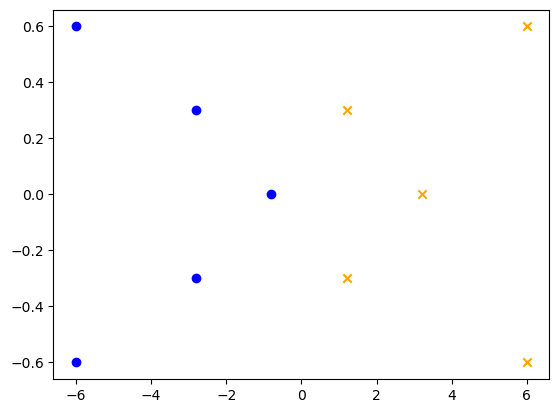

In [3]:
Tri=np.array(
[[-0.8,0.3],
[-0.8,-0.3],
[1.2,0]],dtype=np.float64)
Noise=np.array(
[[-4,0.6],
[-4,-0.6]],dtype=np.float64)

X0=Tri
p0=np.ones(3)

X1=np.concatenate((Tri,Noise))
X1[:,0]-=2
p1=np.ones(5)

X2=np.concatenate((Tri,Noise))
X2[:,0]+=2
X2[3:5,0]+=8

p2=np.ones(5)

plt.scatter(X1[:,0],X1[:,1],c='blue',marker='o')
plt.scatter(X2[:,0],X2[:,1],c='orange',marker='x')
plt.savefig('experiment/Rebuttal/A1_data.png',bbox_inches='tight')

ValueError: too many values to unpack (expected 3)

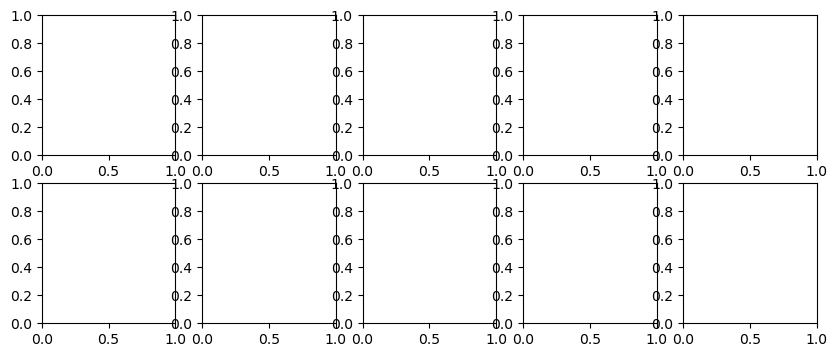

In [4]:
#setup_HKScale=2.2
Lambda=40
setup_HKScale=np.sqrt(2*Lambda)*2/np.pi


tList=np.linspace(0,1,K)
fig,ax=plt.subplots(2,K,figsize=(10,4))
result={}
result['HK-'+str(setup_HKScale)]=[]
result['OPT-'+str(Lambda)]=[]
# solve HK 
params={}
params["setup_HKMode"]=True
params["setup_HKScale"]=setup_HKScale
params["solver_errorGoal"]=1e-4
params["aux_verbose"]=False
params["solver_epsStart"]=1e3*setup_HKScale/1.3 
params["solver_epsTarget"]=0.1*setup_HKScale/1.3 

K=5
# solve HK transport
value,pi=Sinkhorn.SolveHK(p1,X1,p2,X2,HKScale=params["setup_HKScale"],
        SinkhornError=params["solver_errorGoal"],
        epsTarget=params["solver_epsTarget"], epsInit=params["solver_epsStart"],
        returnSolver=False
        )
#print(pi.A)
#pi=np.zeros((3,5))
#pi[0:3,0:3]=np.eye(3)
pi= sparse.csr_matrix(pi)
# from optimal coupling compute tangent vector data
u0,u1,x1,muPerp,nuPerp=LinHK.extractMongeData(pi,p1,p2,X2)
v0,alpha0=LinHK.HKLog(X1,u0,x1,u1,params["setup_HKScale"])

# Solve OPT
u0_opt,p0_opt,M_opt=lopt_embedding(X1,X2,p1,p2,Lambda)
u1_opt,p1_opt,M1_opt=lopt_embedding(X2,X1,p2,p1,Lambda)

Xt_list,pt,X_d,p_d=opt_interpolation(X1,u0_opt,p1,p0_opt,tList)   # (X0,U1,p0,p1_hat,t_list)
Xt1_list,pt1,X_c,p_c=opt_interpolation(X2,u1_opt,p2,p1_opt,np.array([0.]))


for i in range(2):
    for j,t in enumerate(tList):
        # shoot averaged tangent vector back to a measure
        s='C%d-'%i
        if i==0:
            expMu,expT=LinHK.HKExp(p1,X1,t*v0,t*alpha0,HKScale=params["setup_HKScale"])
            #print('expMu is',expMu)
            #print('expT is',expT)
            expT=np.concatenate([expT,X2[nuPerp>0]]) 
            expMu=np.concatenate([expMu,nuPerp[nuPerp>0]*t**2])
            result['HK-'+str(setup_HKScale)].append((expT,expMu))   
            if j==0: 
                ax[i,j].set_ylabel('HK,s=%0.1f'%(setup_HKScale),rotation=90,fontsize=18)

        else:
            expT=np.concatenate([Xt_list[i],X_d,X_c])
            expMu=np.concatenate([pt,(1-t)*p_d,t*p_c])
            result['OPT-'+str(Lambda)].append((expT,expMu))
            if j==0:
                ax[i,j].set_ylabel('OPT,$\lambda=$'+str(Lambda),rotation=90,fontsize=18)

        
        ax[i,j].scatter(expT[:,0],expT[:,1],s=expMu*40,color='blue',marker='o')
        ax[i,j].set_xlim([-7,7])
        ax[i,j].set_ylim([-0.7,0.7])
        if i==1:
            ax[i,j].set_xlabel(r'$t=%0.2f$'%t,fontsize=16)
        #ax[i,j].grid(True,axis='y')
        #ax[i,j].set_yticks([0,1/3,2/3,1])
        #ax[i,j].set_yticklabels(['0','1/3','2/3','1'])
        # if i not in [0,4]:
        
        ax[i,j].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    #plt.subplots_adjust( hspace=0)
#
plt.savefig('experiment/Rebuttal/A2.HK_OPT.png',bbox_inches='tight')
plt.subplots_adjust(wspace=0, hspace=0)
#plt.show()

#torch.save(result,'experiment/Fig1/result_2d.pt')

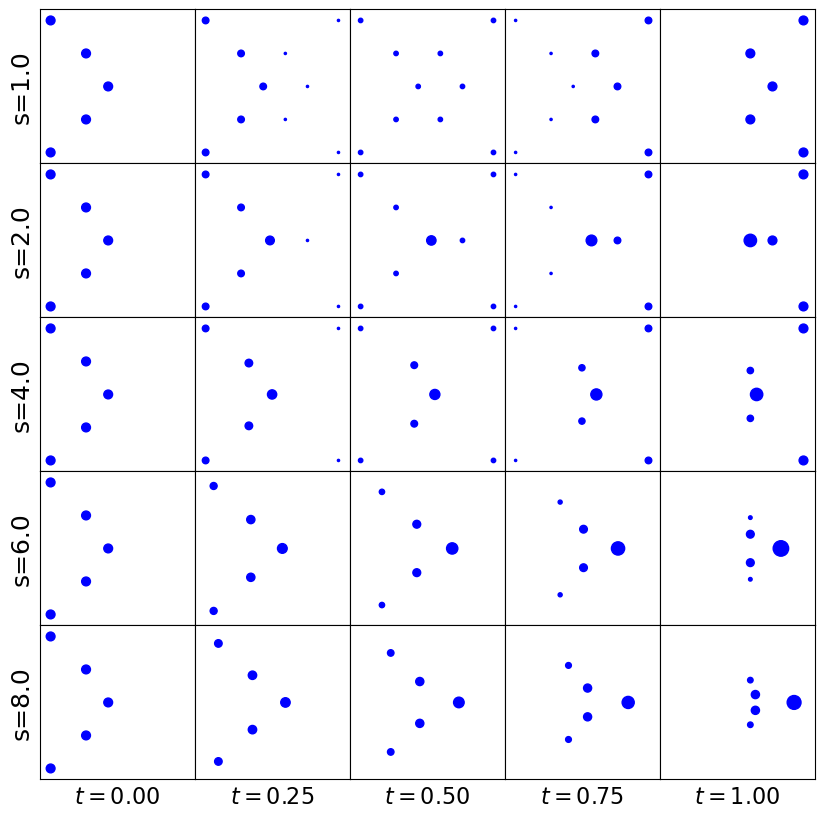

In [5]:
setup_HKScale_list=np.array([1,2,4,6,8],dtype=np.float32)
K=5
tList=np.linspace(0,1,K)
fig,ax=plt.subplots(5,K,figsize=(10,10))
result={}
result['HK-'+str(setup_HKScale)]=[]
result['OPT-'+str(Lambda)]=[]

for (i,setup_HKScale) in enumerate(setup_HKScale_list):
    # solve HK 

    params={}
    params["setup_HKMode"]=True
    params["setup_HKScale"]=setup_HKScale
    params["solver_errorGoal"]=1e-4
    params["aux_verbose"]=False
    params["solver_epsStart"]=1e3*setup_HKScale/1.3 
    params["solver_epsTarget"]=0.1*setup_HKScale/1.3 

    # solve HK transport
    value,gamma=Sinkhorn.SolveHK(p1,X1,p2,X2,HKScale=params["setup_HKScale"],
            SinkhornError=params["solver_errorGoal"],
            epsTarget=params["solver_epsTarget"], epsInit=params["solver_epsStart"],
            returnSolver=False
            )

    # from optimal coupling compute tangent vector data
    u0,u1,x1,muPerp,nuPerp=LinHK.extractMongeData(gamma,p1,p2,X2)
    v0,alpha0=LinHK.HKLog(X1,u0,x1,u1,params["setup_HKScale"])


    for j,t in enumerate(tList):
        # shoot averaged tangent vector back to a measure
        s='C%d-'%i
        expMu,expT=LinHK.HKExp(p1,X1,t*v0,t*alpha0,HKScale=params["setup_HKScale"])
        expT=np.concatenate([expT,X2[nuPerp>0]]) 
        expMu=np.concatenate([expMu,nuPerp[nuPerp>0]*t**2])
        
        ax[i,j].scatter(expT[:,0],expT[:,1],s=expMu*40,color='blue',marker='o')
        ax[i,j].set_xlim([-7,7])
        ax[i,j].set_ylim([-0.7,0.7])
        if j==0: 
            ax[i,j].set_ylabel('s=%0.1f'%(setup_HKScale),rotation=90,fontsize=18)
        if i==4:
            ax[i,j].set_xlabel(r'$t=%0.2f$'%t,fontsize=16)
        ax[i,j].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    #plt.subplots_adjust( hspace=0)
    #
#
plt.subplots_adjust(wspace=0, hspace=0)
#fig.suptitle('This is a somewhat long figure title', fontsize=16)

#plt.title("Linear graph")
plt.savefig('experiment/Rebuttal/A3.HK_multi.png',bbox_inches='tight')

#plt.show()

#torch.save(result,'experiment/Fig1/result_2d.pt')

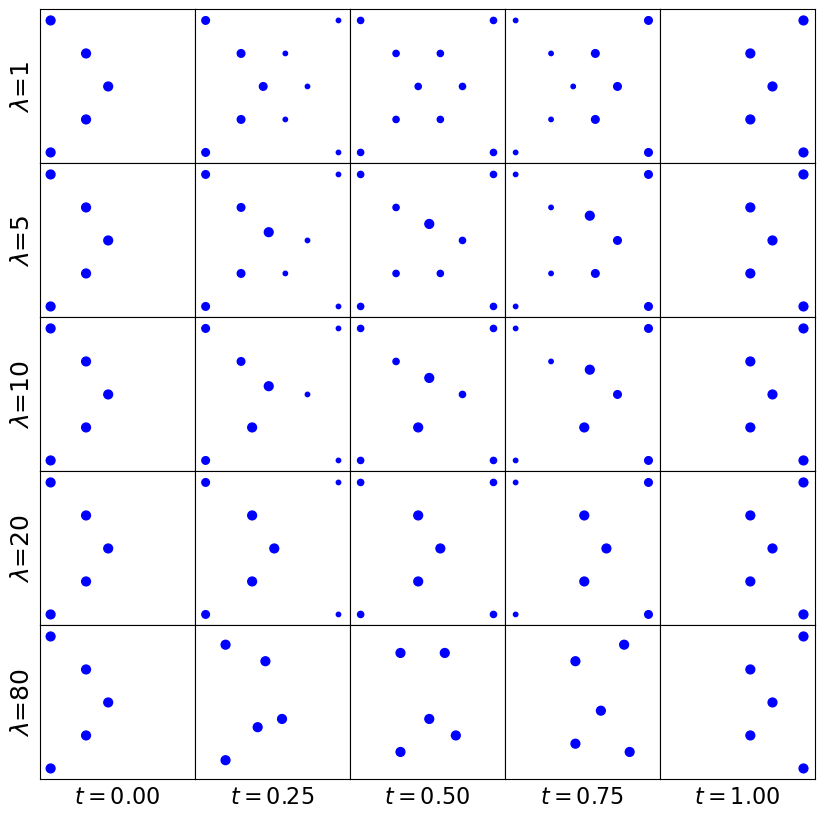

In [33]:
Lambda_list=np.array([1,5,10,20,80],dtype=np.float32)
K0=Lambda_list.shape[0]
K=5
tList=np.linspace(0,1,K)
fig,ax=plt.subplots(K0,K,figsize=(10,10))

for (i,Lambda) in enumerate(Lambda_list):
    # Solve OPT
    u0_opt,p0_opt,M_opt,p1_perp=lopt_embedding(X1,X2,p1,p2,Lambda)
    Xt_list,pt,X_d,p_d=opt_interpolation(X1,u0_opt,p1,p0_opt,tList)   # (X0,U1,p0,p1_hat,t_list)
    X_c=X2[p1_perp>0]
    p_c=p1_perp[p1_perp>0]

    for j,t in enumerate(tList):
        # shoot averaged tangent vector back to a measure
        s='C%d-'%i
        expT=np.concatenate([Xt_list[j],X_d,X_c])
        expMu=np.concatenate([pt,(1-t)*p_d,t*p_c])
        #result['OPT-'+str(Lambda)].append((expT,expMu))
        
        ax[i,j].scatter(expT[:,0],expT[:,1],s=expMu*40,color='blue',marker='o')
        ax[i,j].set_xlim([-7,7])
        ax[i,j].set_ylim([-0.7,0.7])
        if j==0: 
            ax[i,j].set_ylabel('$\lambda$=%0.0f'%(Lambda),rotation=90,fontsize=18)
        if i==K0-1:
            ax[i,j].set_xlabel(r'$t=%0.2f$'%t,fontsize=16)
        ax[i,j].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    #plt.subplots_adjust( hspace=0)
    #
#
plt.subplots_adjust(wspace=0, hspace=0)
#fig.suptitle('This is a somewhat long figure title', fontsize=16)

#plt.title("Linear graph")
plt.savefig('experiment/Rebuttal/A4.opt_multi.png',bbox_inches='tight')

#plt.show()

#torch.save(result,'experiment/Fig1/result_2d.pt')